In [72]:
#These are the libraries you can use.  You may add any libraries directy related to threading if this is a direction
#you wish to go (this is not from the course, so it's entirely on you if you wish to use threading).  Any
#further libraries you wish to use you must email me, james@uwaterloo.ca, for permission.

from IPython.display import display, Math, Latex

import pandas as pd
import numpy as np
import numpy_financial as npf
import yfinance as yf
import matplotlib.pyplot as plt
import random
from datetime import datetime

## Group Assignment
### Team Number: XX
### Team Member Names:
### Team Strategy Chosen: __________(Market Beat or Market Meet)

Disclose any use of AI for this assignment below (detail where and how you used it).  Please see the course outline for acceptable uses of AI.


In [75]:
tickers_file_name = "Tickers_Example.csv"
tickers_file_original = pd.read_csv(tickers_file_name, header = None, names=['Ticker'])

total_investment = 1000000
start_date = "2023-10-01"
end_date = "2024-09-30"
drop_tickers = []
for tick in tickers_file_original['Ticker']:    

    try:

        ticker = yf.Ticker(tick) 

        if ticker.info.get('quoteType')=='NONE':
            # print("phewww", tick)
            tickers_file_original = tickers_file_original[tickers_file_original['Ticker'] != tick]
            continue
                
        if ticker.fast_info.get('currency') not in ['USD', 'CAD']:
            # print("hmmm", tick)
            tickers_file_original = tickers_file_original[tickers_file_original['Ticker'] != tick]
            continue

        history = ticker.history(start = start_date, end = end_date)
        
        trading_days = history['Volume'].resample('ME').count()
        volume = history['Volume'].resample('ME').sum()
        trading_days = trading_days[trading_days>=18]
        volume = volume[volume.index==trading_days.index]
        monthly_volume = volume.mean()

        if monthly_volume<100000: 
            # print("sheesh", tick)
            tickers_file_original = tickers_file_original[tickers_file_original['Ticker'] != tick]

    except:
            # print("ufff", tick)
            pass
        
tickers_file_original = tickers_file_original.reset_index(drop=True)

In [76]:
# Fetch historical data for both indices
sp500 = yf.Ticker("^GSPC").history(start=start_date, end=end_date)['Close']
tsx60 = yf.Ticker("HXT.TO").history(start=start_date, end=end_date)['Close']

# Ensure both dataframes align by date (in case they have missing values)
combined_data = pd.concat([sp500, tsx60], axis=1, keys=['S&P 500', 'TSX 60'])
combined_data = combined_data.dropna()  # Remove any rows with missing data

# Calculate the arithmetic mean for each day
combined_data['Arithmetic Mean'] = combined_data.mean(axis=1)

In [77]:
stocks = {key: 0 for key in tickers_file_original['Ticker'].values}
print(stocks)

{'AAPL': 0, 'ABBV': 0, 'ABT': 0, 'ACN': 0, 'AIG': 0, 'AMZN': 0, 'AXP': 0, 'BA': 0, 'BAC': 0, 'BB.TO': 0, 'BIIB': 0, 'BK': 0, 'BLK': 0, 'BMY': 0, 'C': 0, 'CAT': 0, 'CL': 0, 'KO': 0, 'LLY': 0, 'LMT': 0, 'MO': 0, 'MRK': 0, 'PEP': 0, 'PFE': 0, 'PG': 0, 'PM': 0, 'PYPL': 0, 'QCOM': 0, 'RY.TO': 0, 'SHOP.TO': 0, 'T.TO': 0, 'TD.TO': 0, 'TXN': 0, 'UNH': 0, 'UNP': 0, 'UPS': 0, 'USB': 0}


In [78]:
current_data = pd.DataFrame()
beta_df = pd.DataFrame(index=list(stocks.keys()), columns=['beta','correlation'])

for i in stocks:
    current_data[i] = yf.Ticker(i).history(start=start_date, end=end_date)["Close"]
    covariance = combined_data["Arithmetic Mean"].cov(current_data[i])
    variance = combined_data["Arithmetic Mean"].var()
    beta = covariance / variance

    correlation = combined_data["Arithmetic Mean"].corr(current_data[i])
    beta_df.loc[i,'correlation'] = correlation
    beta_df.loc[i,'beta'] = beta

beta_df

,beta,correlation
AAPL,0.063189,0.677311
ABBV,0.070052,0.853566
ABT,0.018882,0.572957
ACN,0.009865,0.081997
AIG,0.023564,0.880999
AMZN,0.084611,0.923631
AXP,0.161251,0.970934
BA,-0.062194,-0.534315
BAC,0.021504,0.964995
BB.TO,-0.003014,-0.865166


In [79]:
for ticker in beta_df.index:
    beta = beta_df.loc[ticker, 'beta']
    beta_score = max(0, 10 - abs(1 - beta) * 10)  # Subtracting the absolute difference from 10
    stocks[ticker] += beta_score

# Assign points based on correlation
for ticker in beta_df.index:
    correlation = beta_df.loc[ticker, 'correlation']
    if correlation > 0.85:
        stocks[ticker] += 10  # High correlation bonus
    elif correlation > 0.70:
        stocks[ticker] += 5   # Medium correlation bonus
    elif correlation > 0.50:
        stocks[ticker] += 2   # Low correlation bonus
stocks = dict(sorted(stocks.items(), key=lambda item: item[1], reverse=True))
stocks

{'LLY': 15.648540369215198,
 'BLK': 13.146357736971684,
 'CAT': 11.673485345751702,
 'AXP': 11.612506395850964,
 'QCOM': 11.180170308610236,
 'TXN': 10.88846206280663,
 'AMZN': 10.846111336821947,
 'ABBV': 10.70052032591984,
 'RY.TO': 10.686388555736169,
 'CL': 10.475945764564754,
 'PG': 10.418519886543374,
 'C': 10.350543903202091,
 'BK': 10.350155407242914,
 'AIG': 10.23564415642431,
 'BAC': 10.215036939884307,
 'KO': 10.208470029239864,
 'PM': 5.42078497562278,
 'MRK': 5.34395208446459,
 'MO': 5.188127087520318,
 'PYPL': 5.175542865212607,
 'USB': 5.148792121712448,
 'LMT': 3.513703323532008,
 'AAPL': 2.6318919363277935,
 'UNP': 2.4611068974618,
 'ABT': 2.188824109677462,
 'PEP': 2.1747225533882286,
 'UNH': 0.32791906284825245,
 'SHOP.TO': 0.15202835271719017,
 'ACN': 0.09865329897691844,
 'TD.TO': 0.02220979846015858,
 'BA': 0,
 'BB.TO': 0,
 'BIIB': 0,
 'BMY': 0,
 'PFE': 0,
 'T.TO': 0,
 'UPS': 0}

In [146]:
sample_stocks = dict(list(stocks.items())[:20])
sample_stocks

{'LLY': 15.648540369215198,
 'BLK': 13.146357736971684,
 'CAT': 11.673485345751702,
 'AXP': 11.612506395850964,
 'QCOM': 11.180170308610236,
 'TXN': 10.88846206280663,
 'AMZN': 10.846111336821947,
 'ABBV': 10.70052032591984,
 'RY.TO': 10.686388555736169,
 'CL': 10.475945764564754,
 'PG': 10.418519886543374,
 'C': 10.350543903202091,
 'BK': 10.350155407242914,
 'AIG': 10.23564415642431,
 'BAC': 10.215036939884307,
 'KO': 10.208470029239864,
 'PM': 5.42078497562278,
 'MRK': 5.34395208446459,
 'MO': 5.188127087520318,
 'PYPL': 5.175542865212607}

In [148]:
############################################################## CODE TO CALCULATE MODEL PRICE ###########################################################

index_shares = 1000000 / combined_data.loc[(combined_data.index[0]),"Arithmetic Mean"]
index_value = pd.DataFrame(index=combined_data.index,columns=["Value"])
index_value["Value"] = combined_data["Arithmetic Mean"] * index_shares
model_price = index_value.loc[(index_value.index[(len(index_value.index)) - 1]),"Value"]
model_price

1337523.2006996132

In [150]:
new_df = current_data[list(selected_stocks.keys())]
#shares = 0
#money = 1000000 / 13
#total = pd.DataFrame(index=new_df.index,columns=["Value"])
#total["Value"] = [0]*(len(total.index))
#for i in new_df.columns.tolist():
#    shares = money / new_df.loc[(new_df.index[0],i)]
#    total["Value"] += (new_df[i] * shares)
#total

In [152]:
from itertools import combinations_with_replacement

In [164]:
def get_valid_weight_combinations(num_stocks):
    weight_combinations = []
    min_weight = 0.04  # 4% of model_price
    max_weight = 0.15  # 15% of model_price
    for comb in combinations_with_replacement(np.arange(min_weight, max_weight, 0.01), num_stocks):
        if sum(comb) <= 1:  # Ensure total weight is 100%
            weight_combinations.append(comb)
    return weight_combinations

In [175]:
def calculate_portfolio_value(df, selected_stocks, weights):
    cur_df = new_df[selected_stocks]
    first_row = cur_df.iloc[0]  # First row of stock prices
    last_row = cur_df.iloc[-1]  # Last row of stock prices
    investment = 1000000
    sum = 0
    for i in range(0,len(weights)):
        shares = ((weights[i]*investment)/first_row.iloc[i])
        sum += (last_row.iloc[i] * shares)
    return sum

In [177]:

best_diff = 0 
# Iterate over numbers of stocks between 12 and 20
for num_stocks in range(12, 21):  # Between 12 and 20 stocks
    selected_stocks = list(sample_stocks.keys())[:num_stocks]  # Select first 'num_stocks' from the ranking
        
    # Generate weight combinations for the selected stocks
    weight_combinations = get_valid_weight_combinations(num_stocks)
    for weights in weight_combinations:
            # Calculate portfolio value
            portfolio_value = calculate_portfolio_value(new_df, selected_stocks, weights)
            diff = abs(portfolio_value - model_price)
            
            # Track the best combination
            if diff < best_diff:
                best_diff = diff
                best_combination = (selected_stocks, weights)
print("Best Stock Combination:", best_combination)
print("Portfolio Value Difference:", best_diff)  

KeyError: "['AIG'] not in index"

In [124]:
#index_shares = 1000000 / combined_data.loc[(combined_data.index[0]),"Arithmetic Mean"]
#index_value = pd.DataFrame(index=combined_data.index,columns=["Value"])
#index_value["Value"] = combined_data["Arithmetic Mean"] * index_shares
#final_value = index_value.loc[(index_value.index[(len(index_value.index)) - 1]),"Value"]



#plt.plot(total.index,total["Value"],label='Stocks Portfolio Value', color='blue')
#plt.plot(combined_data.index,index_value["Value"],label='Average Index Portfolio Value', color='green')
# Set the title and labels
#plt.title('Portfolio Value Comparison: Average Index vs Stocks')
#plt.xlabel('Date')
#plt.ylabel('Portfolio Value (CAD)')

# Show the legend
#plt.legend()

# Show grid and format the x-axis labels
#plt.grid(True)
#plt.xticks(rotation=45)
#plt.tight_layout()

# Display the plot
#plt.show()
#print(final_value)
#print(my_value)

1337523.2006996132
1520526.3261625953


52163.40482728492


200628.48010494196

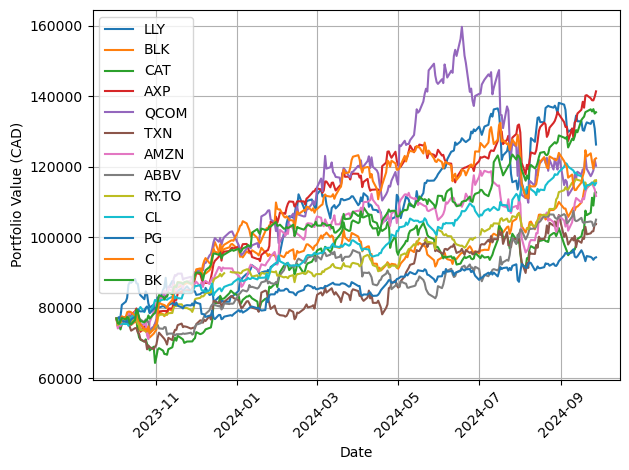

In [179]:
for i in new_df.columns.tolist():
    shares = money / new_df.loc[(new_df.index[0],i)]
    plt.plot(new_df.index,new_df[i] * shares,label=i)
plt.xlabel('Date')
plt.ylabel('Portfolio Value (CAD)')

# Show the legend
plt.legend()

# Show grid and format the x-axis labels
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Display the plot
plt.show()

## Contribution Declaration

The following team members made a meaningful contribution to this assignment:

Insert Names Here.